# Canny filter for RGB images

## Introducción

En esta práctica se propone construir un filtro de Canny para detectar bordes en imágenes RGB. Para ello, se procede a adaptar el código de esta [página](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123), donde ya se ofrece el filtro para imágenes en escala de grises. 

El código original implementa una  conversión de RGB a escala de grises a las imágenes de entrada antes de proceder con los cálculos propios del filtro. Para adaptar esta implementación a imágenes RGB, se han realizado los siguientes pasos: 

1. Eliminar la conversión a escala de grises. 
2. El suavizado con el kernel gaussiano se realiza sobre los 3 canales de la imagen. 
3. Se computan los gradientes y sus magnitudes en cada uno de los 3 canales por separado. Esto se realiza en la función `detect`.
4. Por cada píxel, se selecciona el gradiente cuya magnitud es máxima entre los 3 canales. Se almacena su norma y orientación en una imagen 2D. Esto se realiza en la función `sobel_filters`. 
5. El resto de la implementación (_non maxima supression_ , umbralización e histéresis) se deja igual. No son necesarios más pasos ya que se dispone de una imagen 2D con gradientes y magnitudes.

En el código aparecen comentarios explicativos en las líneas modificadas o añadidas. 

## Comienzo de la práctica

Se importan las librerías necesarias

In [111]:
import numpy as np
import skimage
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import scipy.misc as sm

from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc

La clase `cannyEdgeDetector` contiene aquellos métodos necesarios para ejecutar el filtro de Canny

In [147]:
class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
        
        # Magnitud y orientación del gradiente en cada canal
        G = np.zeros((img.shape))
        theta = np.zeros((img.shape))
        
        for channel in range(3):
            Ix = ndimage.filters.convolve(img[:,:,channel], Kx)
            Iy = ndimage.filters.convolve(img[:,:,channel], Ky)

            G[:,:,channel] = np.hypot(Ix, Iy)
            G[:,:,channel] = G[:,:,channel] / G[:,:,channel].max() * 255
            theta[:,:,channel] = np.arctan2(Iy, Ix)
            
        ind = np.argmax(G, axis = -1) # canal con el gradiente de mayor norma 
        theta_final = np.zeros((ind.shape)) # orientación del gradiente con mayor norma
        for i in range(ind.shape[0]): # filas
            for j in range(ind.shape[1]): # columnas
                theta_final[i,j] = theta[i,j,ind[i,j]]
        
        #se devuelven las normas y magnitudes de los gradientes con mayor norma entre canales
        return (np.amax(G, axis = -1), theta_final) #np.amax -> elemento de valor máximo en un eje
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):
            channels_smooth = np.zeros((img.shape))
            for channel in range(3): #número de canales
                #convolución sobre cada canal
                channels_smooth[:,:,channel] = convolve(img[:,:,channel], self.gaussian_kernel(self.kernel_size, self.sigma))
            self.img_smoothed = channels_smooth 
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)
        return self.imgs_final

`load_data` se encarga de leer todas la imágenes del directorio `faces_imgs`.

In [151]:
def load_data(dir_name = 'faces_imgs'):    
    '''
    Load images from the "faces_imgs" directory
    Images are in JPG and we convert it to gray scale images
    '''
    imgs = []
    for filename in os.listdir(dir_name):
        if os.path.isfile(dir_name + '/' + filename):
            img = mpimg.imread(dir_name + '/' + filename)
            #img = rgb2gray(img) # imágenes en RGB, no en escala de grises
            imgs.append(img)
    return imgs

`visualize` se encarga de mostrar las imágenes por pantalla en el formato marcado `format`. 

In [152]:
def visualize(imgs, format=None, gray=False):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
      #  if img.shape[0] == 3:
       #     img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(2, 2, plt_idx)
        plt.imshow(img, format)
    plt.show()

#### Paso 1

Se cargan las imágenes originales y se muestran.

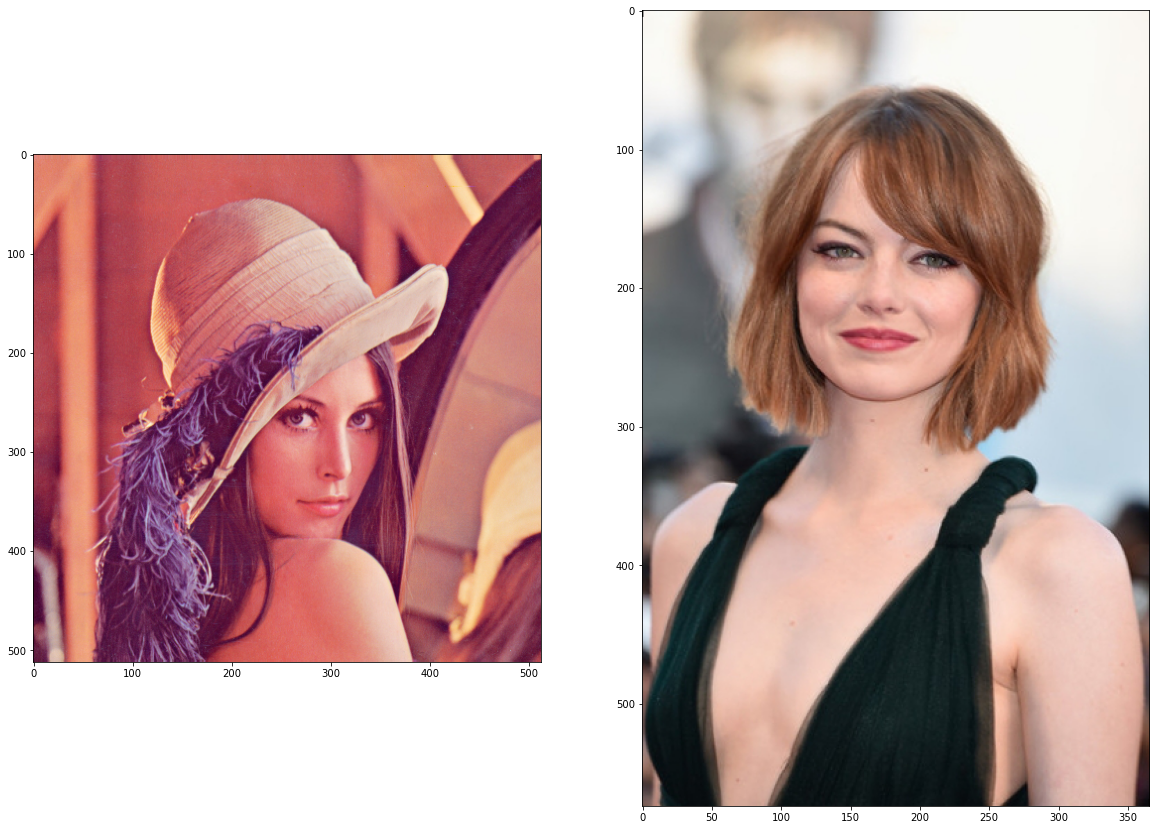

In [154]:
imgs = load_data()
visualize(imgs)

#### Paso 2

Se crea una instancia de la clase `cannyEdgeDetector`. Se especifican parámetros clave para la ejecución del filtro, como el tamaño del kernel gaussiano o los umbrales para la histéresis. Los valores de dichos parámetros son los mismos que en código original, ya que han dado buenos resultados también para esta versión. 

In [157]:
detector = cannyEdgeDetector(imgs, sigma=1.4, kernel_size=5, lowthreshold=0.09, highthreshold=0.17, weak_pixel=100)

#### Paso 3

Se computan los bordes con el método `detect`.

In [158]:
edges = detector.detect()

#### Paso 4

Finalmente se visualiza el resultado. 

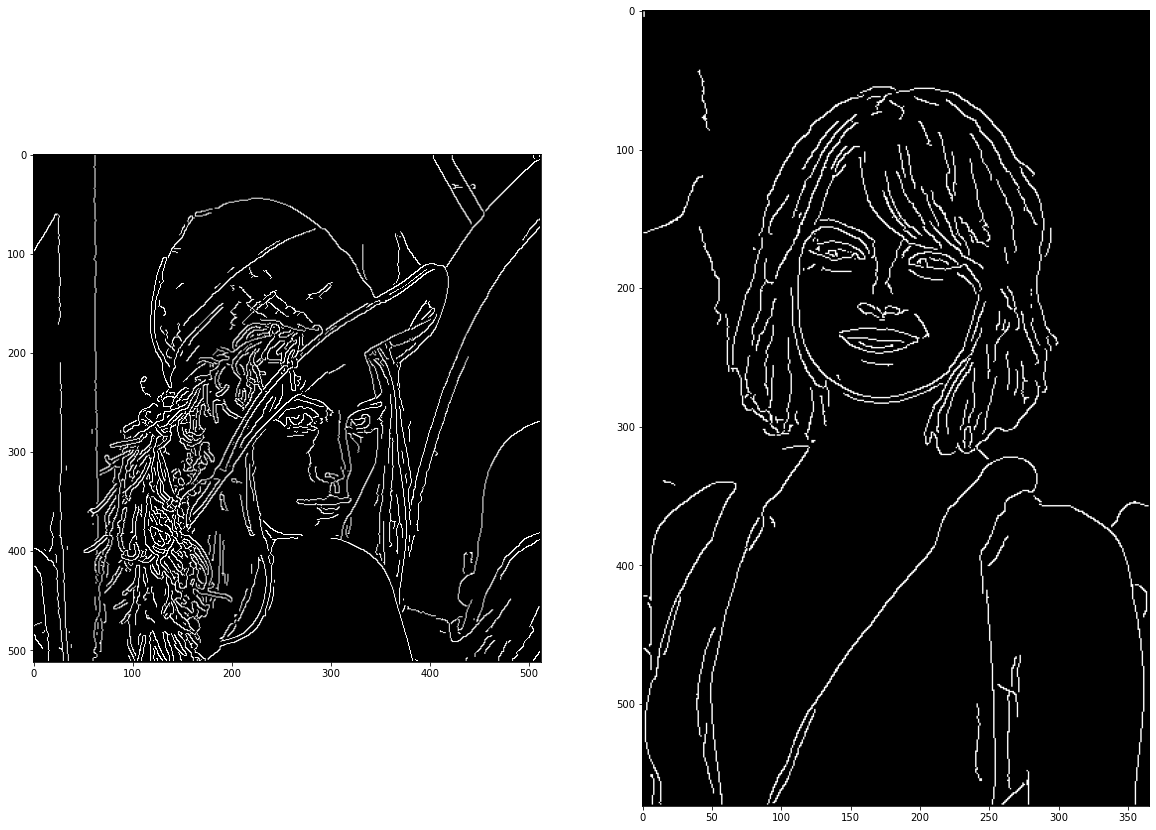

In [159]:
visualize(edges, 'gray')

**Observacion:** se desconoce el motivo por el cual algunos píxeles de bordes en la primera imagen aparecen con una tonalidad grisácea, como en la nariz. En principio, cuando se realiza el proceso de histéresis, todos los píxeles son asignados un valor de 255 o 0, dependiendo de si es borde o no. Quizá pueda ser un fallo en la visualización de la librería Matplotlib. A continuación se verifica si existen valores entre 0 y 255 en la primera imagen.

In [175]:
cond1 = np.where(final[0] > 0, True, False)
cond2 = np.where(final[0] < 255, True, False)

results = np.logical_and(cond1,cond2)

print(results.any())

False


**Resolución:** no existen valores entre 0 y 255 en la primera imagen. Así pues, debe ser alguna cuestión relacionada con la librería Matplotlib.